In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import display, HTML, SVG

In [2]:
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_curve, accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score
from sklearn.metrics import auc, precision_recall_curve, roc_curve, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score
import pandas
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import ast
import seaborn
from sklearn.calibration import calibration_curve
from scipy.stats import binom_test, fisher_exact, chi2_contingency

from db import Result
import math
import papermill as pm
from vis.utils.utils import load_img
from tabulate import tabulate
import svgutils.transform as sg

from config import config
pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/intrepidlemon/.local/share/virtualenvs/deep-ultrasound-eb7oaR1r/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [3]:
from evaluate import load, get_results, get_labels, adjusted_wald, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, accession_from_filename, plot_expert_confusion, plot_grad_cam, get_expert_results

In [4]:
from data import describe, all_features, data, print_describe, load_single
from run import characterize_data

In [5]:
from collections import defaultdict

# All models

In [6]:
DIRECTORY = os.path.join(os.environ["DATA_DIR"], "liver-ultrasound")
CROPS = ["free", "fixed", "uncertain-free", "uncertain-fixed"]
DESCRIPTIONS = {
    "free": "free-0",
    "fixed": "fixed-0", 
    "uncertain-free": "c3-c4-free-0",
    "uncertain-fixed": "c3-c4-fixed-0", 
}
DATA_FOLDERS = {
    ("free"): os.path.join(DIRECTORY, "free"), 
    ("fixed"): os.path.join(DIRECTORY, "fixed"), 
    ("uncertain-free"): os.path.join(DIRECTORY, "c3-c4-free"), 
    ("uncertain-fixed"): os.path.join(DIRECTORY, "c3-c4-fixed"), 
}
MODALITIES = CROPS
MODALITY_KEY = {
    "free": "Free - Complete",
    "fixed": "Fixed - Complete", 
    "uncertain-free": "Free - Uncertain",
    "uncertain-fixed": "Fixed - Uncertain", 
}

In [7]:
for crop in CROPS: 
    results = Result.query.filter(Result.description == DESCRIPTIONS[(crop)]).all()
    pd = pandas.DataFrame([{
        "train_accuracy": r.train_accuracy,
        "accuracy": r.accuracy, 
        "test_accuracy": r.test_accuracy, 
        "uuid": r.uuid
    } for r in results])
    print(crop)
    print(pd.nlargest(10, "accuracy"))

free
     train_accuracy  accuracy  test_accuracy  \
17            0.945     0.849          0.833   
51            0.883     0.843          0.774   
84            0.927     0.831          0.762   
90            0.786     0.831          0.798   
148           0.903     0.826          0.798   
8             0.888     0.826          0.821   
39            0.903     0.826          0.786   
44            0.862     0.826          0.738   
95            0.829     0.826          0.833   
198           0.824     0.826          0.786   

                                     uuid  
17   04cfb42d-3e0b-4516-aa85-56f19cb4d6b9  
51   026f448c-ba29-4a3c-9e78-e6a916fa8823  
84   b68d3584-10f4-4bb5-9628-6908c9fce867  
90   13123b1c-c0f0-4b15-836e-3860726caf2d  
148  2fb884d2-fad4-4e04-a19f-203699b0dcb9  
8    9b7be1a8-d55c-48ec-8e79-6cf685b7effc  
39   8696f6fd-b58f-43a4-98c7-6e69e238240d  
44   67012f8b-576b-4950-b613-28f21d102100  
95   29d65a54-cea9-43cd-8136-ae3ae2eaaed7  
198  b1652194-37d6-4e1e-88

In [8]:
UUIDS = {
    ("free"): "04cfb42d-3e0b-4516-aa85-56f19cb4d6b9",
    ("fixed"): "cbd87d38-62c5-4196-9c5f-d967eac37085", 
    ("uncertain-free"): "9eecc121-a682-4be8-9aa1-f43f4a8b69a7",
    ("uncertain-fixed"): "fd0391b6-3c63-48d9-a0b4-dc0923f48c32",
}

In [9]:

def get_pr_data_for_modality(dataset, comparison_models=[], modalities=MODALITIES): 
    results = list()
    points = list()
    for modality in modalities: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        print(modality, len(labels), len(probabilities), len(predictions))
        acc = accuracy_score(labels, predictions)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats(labels, probabilities)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = None
        for k in dataset.keys(): 
            if "labels" in k: 
                labels = dataset[k]
                break
        predictions = [p > 0.5 for p in probabilities]
        print(modality, len(labels), len(probabilities), len(predictions))
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        stats = calculate_confusion_matrix_stats(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc),
            "precision": stats["PPV"][1],
            "recall": stats["TPR"][1],
        })
        for p, r in zip(precision, recall): 
            results.append({ "precision": p, "recall": r, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], pr_auc, acc)})           
    return results, pr_auc, []
        
def plot_multiple_precision_recall(dataset, experts=[], comparison_models=[], modalities=MODALITIES):
    results, auc, points = get_pr_data_for_modality(dataset, comparison_models, modalities=modalities)        
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = None
            for k in dataset.keys(): 
                if "labels" in k: 
                    labels = dataset[k]
                    break
            predictions = expert
            stats = calculate_confusion_matrix_stats(labels, predictions)
            acc = accuracy_score(labels, predictions)
            points.append({
                "precision": stats["PPV"][1],
                "recall": stats["TPR"][1],                
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc), 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="recall",
        y="precision",
        hue="modality",
        ax=ax, 
        err_style=None,
    )
    if points: 
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="recall",
            y="precision",
            hue="experts",
            style="experts",                        
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },            
            ax=ax,
        )
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_roc_data_for_modality(dataset, comparison_models=[], modalities=MODALITIES): 
    results = list()
    points = list()
    for modality in modalities: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats(labels, probabilities)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = None
        for k in dataset.keys(): 
            if "labels" in k: 
                labels = dataset[k]
                break
        predictions = [p > 0.5 for p in probabilities]
        fpr, tpr, _ = roc_curve(labels, probabilities, drop_intermediate=False)
        roc_auc = roc_auc_score(labels, probabilities)
        stats = calculate_confusion_matrix_stats(labels, predictions)
        acc = accuracy_score(labels, predictions)
        points.append({
            "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc),
            "fpr": stats["FPR"][1],
            "tpr": stats["TPR"][1],
        })
        for f, t in zip(fpr, tpr): 
            results.append({ "fpr": f, "tpr": t, "modality": "{} (auc={:.2f}, acc={:.2f})".format(MODALITY_KEY[modality], roc_auc, acc)})        
    return results, roc_auc, []

def get_reliability_data_for_modality(dataset, comparison_models=[], n_bins=10, modalities=MODALITIES): 
    results = list()
    points = list()
    for modality in modalities: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=n_bins)
        points.append({
            "modality": "{}".format(MODALITY_KEY[modality]),
            "positives": positives,
            "MPV": mean_predicted_value,
        })
        for p, m in zip(positives, mean_predicted_value): 
            results.append({ "positives": p, "mpv": m, "modality": "{}".format(MODALITY_KEY[modality])})
    for probabilities in comparison_models: 
        modality = "Radiomics"
        labels = None
        for k in dataset.keys(): 
            if "labels" in k: 
                labels = dataset[k]
                break
        positives, mean_predicted_value = calibration_curve(labels, probabilities, n_bins=n_bins)
        points.append({
            "modality": "{}".format(MODALITY_KEY[modality]),
            "positives": positives,
            "MPV": mean_predicted_value,
        })
        for p, m in zip(positives, mean_predicted_value): 
            results.append({ "positives": p, "mpv": m, "modality": "{}".format(MODALITY_KEY[modality])})        
    return results

def plot_multiple_reliability_curve(dataset, comparison_models=[], n_bins=10, modalities=MODALITIES):
    results = get_reliability_data_for_modality(dataset, comparison_models, n_bins, modalities=modalities)
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="mpv",
        y="positives",
        hue="modality",
        ax=ax,
        err_style=None,
    )
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def plot_multiple_roc_curve(dataset, experts=[], comparison_models=[], modalities=MODALITIES):
    results, auc, points = get_roc_data_for_modality(dataset, comparison_models, modalities=modalities)
    if len(experts) > 0:
        for i, expert in enumerate(experts): 
            labels = None
            for k in dataset.keys(): 
                if "labels" in k: 
                    labels = dataset[k]
                    break
            predictions = expert
            stats = calculate_confusion_matrix_stats(labels, predictions)
            acc = accuracy_score(labels, predictions)            
            points.append({
                "fpr": stats["FPR"][1],
                "tpr": stats["TPR"][1],
                "experts": "Expert {} (acc={:.2f})".format(i + 1, acc),                 
            })
    fig, ax = plt.subplots()
    seaborn.lineplot(
        data=pandas.DataFrame(results),
        x="fpr",
        y="tpr",
        hue="modality",
        ax=ax,
        err_style=None,
    )
    if points:     
        seaborn.scatterplot(
            data=pandas.DataFrame(points),
            x="fpr",
            y="tpr",
            hue="experts",
            style="experts",            
            ax=ax,
            markers=["o", "v", "s", "P"],
            palette={ p["experts"]: "black" for p in points },
        )
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_ylim(-0.04, 1.04)
    ax.set_xlim(-0.04, 1.02)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return fig

def get_statistics(dataset, experts=[], comparison_models=[], modalities=MODALITIES): 
    results = list()
    for modality in modalities: 
        labels = dataset["{}-labels".format(modality)]
        probabilities = dataset["{}-probabilities".format(modality)]
        predictions = dataset["{}-predictions".format(modality)]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats(labels, probabilities), 
            "Modality": [MODALITY_KEY[modality], MODALITY_KEY[modality]], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])], 
        } 
        # remove more that are not relevant to imbalanced datasets
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]    
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]
        d["acc-low"], d["acc-high"] = adjusted_wald(d["Acc"][1], len(labels))
        results.append(pandas.DataFrame(d).iloc[[1]])
    for i, expert in enumerate(experts): 
        for k in dataset.keys(): 
            if "labels" in k: 
                labels = dataset[k]
                break
        predictions = expert
        f1 = f1_score(labels, predictions)        
        d = {
            "F1 Score": [f1, f1],            
            **calculate_confusion_matrix_stats(labels, np.array(predictions)),             
            "Modality": ["Expert {}".format(i + 1), "Expert {}".format(i + 1)], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        }
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]               
        del d["FPR"]
        del d["FNR"]        
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        d["acc-low"], d["acc-high"] = adjusted_wald(d["Acc"][1], len(labels))
        results.append(pandas.DataFrame(d).iloc[[1]])
    for probabilities in comparison_models: 
        labels = None
        for k in dataset.keys(): 
            if "labels" in k: 
                labels = dataset[k]
                break
        predictions = [p > 0.5 for p in probabilities]
        roc_auc = roc_auc_score(labels, probabilities)
        precision, recall, _ = precision_recall_curve(labels, probabilities)
        pr_auc = auc(recall, precision)
        f1 = f1_score(labels, predictions)
        d = {
            "F1 Score": [f1, f1],            
            "ROC AUC": [roc_auc, roc_auc], 
            "PR AUC": [pr_auc, pr_auc],
            **calculate_confusion_matrix_stats(labels, probabilities), 
            "Modality": ["Radiomics", "Radiomics"], 
            "Total": [len(labels), len(labels)], 
            "Malignant": [len([l for l in labels if l]), len([l for l in labels if l])], 
            "Benign": [len([l for l in labels if not l]), len([l for l in labels if not l])],             
        } 
        # remove more that are not relevant to imbalanced datasets (remove from article too)
        del d["TP"]
        del d["TN"]
        del d["FN"]
        del d["FP"]         
        del d["FPR"]
        del d["FNR"]
        d["Acc (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["Acc"][1], *adjusted_wald(d["Acc"][1], len(labels)))]
        d["TPR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TPR"][1], *adjusted_wald(d["TPR"][1], len([l for l in labels if l])))]
        d["TNR (95% CI)"] = ["", "{:.2f} ({:.2f}-{:.2f})".format(d["TNR"][1], *adjusted_wald(d["TNR"][1], len([l for l in labels if not l])))]        
        d["acc-low"], d["acc-high"] = adjusted_wald(d["Acc"][1], len(labels))
        results.append(pandas.DataFrame(d).iloc[[1]])

    return pandas.concat(results, axis=0, sort=False).set_index("Modality")

In [10]:
TRAIN = dict()
VALIDATION = dict()
TEST = dict()

for crop in CROPS: 
    result = Result.query.filter(Result.uuid == UUIDS[crop]).first()
    MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, result.uuid, result.model)
    model = load(MODEL)
    dataset = load_single("{}/train".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    TRAIN["{}-labels".format(crop)] = labels
    TRAIN["{}-predictions".format(crop)] = predictions
    TRAIN["{}-probabilities".format(crop)] = probabilities
    dataset = load_single("{}/validation".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    VALIDATION["{}-labels".format(crop)] = labels
    VALIDATION["{}-predictions".format(crop)] = predictions
    VALIDATION["{}-probabilities".format(crop)] = probabilities
    dataset = load_single("{}/test".format(DATA_FOLDERS[crop]))
    probabilities = get_results(model, dataset)
    predictions = transform_binary_predictions(probabilities)
    labels = get_labels(dataset)
    TEST["{}-labels".format(crop)] = labels
    TEST["{}-predictions".format(crop)] = predictions
    TEST["{}-probabilities".format(crop)] = probabilities
    # TODO: reset model memory usage
    
COMPLETE_TRAIN = dict()
COMPLETE_VALIDATION = dict()
COMPLETE_TEST = dict()
UNCERTAIN_TRAIN = dict()
UNCERTAIN_VALIDATION = dict()
UNCERTAIN_TEST = dict()

for k, v in TRAIN.items(): 
    if "uncertain" in k: 
        UNCERTAIN_TRAIN[k] = v
    else: 
        COMPLETE_TRAIN[k] = v

for k, v in VALIDATION.items(): 
    if "uncertain" in k: 
        UNCERTAIN_VALIDATION[k] = v
    else: 
        COMPLETE_VALIDATION[k] = v
        
for k, v in TEST.items(): 
    if "uncertain" in k: 
        UNCERTAIN_TEST[k] = v
    else: 
        COMPLETE_TEST[k] = v
        
COMPLETE_MODALITIES = ["free", "fixed"]        
UNCERTAIN_MODALITIES = ["uncertain-free", "uncertain-fixed"]            

Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [11]:
complete = load_single("{}/test".format(DATA_FOLDERS["free"]))
uncertain = load_single("{}/test".format(DATA_FOLDERS["uncertain-free"]))
complete_experts = all_features(features=config.EXPERTS)
uncertain_experts = all_features(features=config.UNCERTAIN_EXPERTS)


Found 79 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [12]:
f = all_features(features=config.FEATURES, fieldnames=["diagnosis", "malignant", "evidence", "category"])

In [20]:
malignancy = f[1]
category = f[3]

In [21]:
complete_expert_predictions = [list(), list()]
uncertain_expert_predictions = [list(), list()]

complete_data = list()
uncertain_data = list()

for i, n in enumerate(complete.filenames): 
    s = n.split("/")[1].replace("free-", "").replace(".jpeg", "")
    t = s.split("-")[0]
    complete_expert_predictions[0].append(int(complete_experts[0][s]))
    complete_expert_predictions[1].append(int(complete_experts[1][s]))
    complete_data.append({
        "expert 1": int(complete_experts[0][s]), 
        "expert 2": int(complete_experts[1][s]), 
        "free crop": COMPLETE_TEST["free-predictions"][i], 
        "fixed crop":  COMPLETE_TEST["fixed-predictions"][i], 
        "label": 1 if malignancy[t] == "malignant" else 0, 
        "code": category[t], 
    })
    
for i, n in enumerate(uncertain.filenames): 
    s = n.split("/")[1].replace("free-", "").replace(".jpeg", "")
    t = s.split("-")[0]    
    uncertain_expert_predictions[0].append(int(uncertain_experts[0][s]))
    uncertain_expert_predictions[1].append(int(uncertain_experts[1][s]))
    uncertain_data.append({
        "expert 1": int(uncertain_experts[0][s]), 
        "expert 2": int(uncertain_experts[1][s]), 
        "free crop": UNCERTAIN_TEST["uncertain-free-predictions"][i], 
        "fixed crop":  UNCERTAIN_TEST["uncertain-fixed-predictions"][i], 
        "label": 1 if malignancy[t] == "malignant" else 0, 
        "code": category[t], 
    })
complete_pd = pandas.DataFrame(complete_data)
uncertain_pd = pandas.DataFrame(uncertain_data)   

In [22]:
complete_pd.code.unique()

array(['C3', 'C2', 'C5', 'C4'], dtype=object)

In [23]:
combined_accuracy = list()

for code in complete_pd.code.unique(): 
    current = complete_pd[complete_pd.code == code]
    for crop in ["free crop", "fixed crop"]: 
        combined_accuracy.append({
            "predictor": "ResNet", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[[crop]])
        })
        combined_accuracy.append({
            "predictor": "expert 1", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 1"]])
        })
        combined_accuracy.append({
            "predictor": "expert 2", 
            "code": code, 
            "dataset": "complete set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 2"]])
        })
        
for code in uncertain_pd.code.unique():
    current = uncertain_pd[uncertain_pd.code == code]
    for crop in ["free crop", "fixed crop"]: 
        combined_accuracy.append({
            "predictor": "ResNet", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[[crop]])
        })
        combined_accuracy.append({
            "predictor": "expert 1", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 1"]])
        })
        combined_accuracy.append({
            "predictor": "expert 2", 
            "code": code, 
            "dataset": "uncertain diagnosis set", 
            "crop": crop, 
            "accuracy": accuracy_score(current.label, current[["expert 2"]])
        })
                
combined_accuracy = pandas.DataFrame(combined_accuracy)

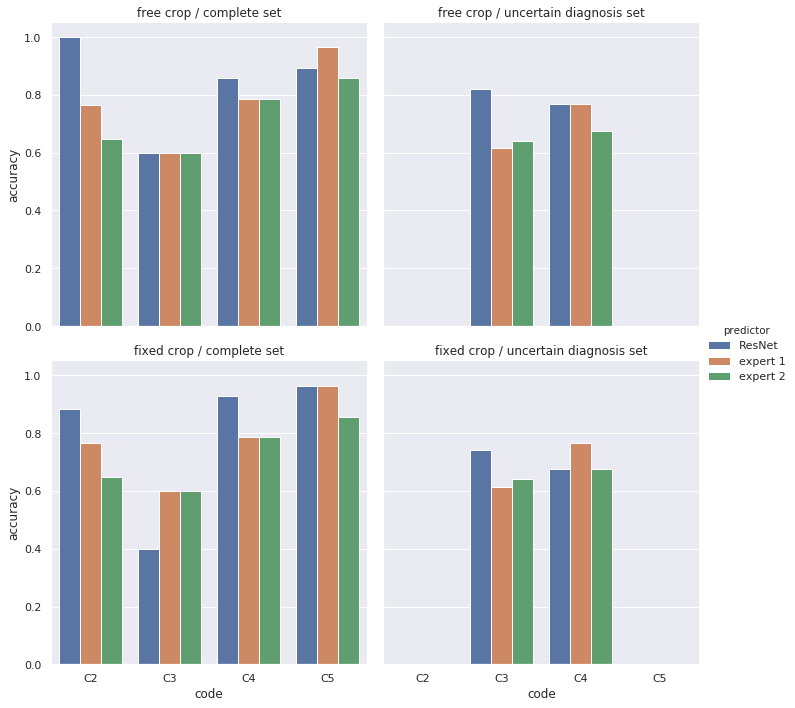

In [24]:
fig = seaborn.catplot(
    x="code", 
    y="accuracy", 
    hue="predictor", 
    row="crop", 
    col="dataset", 
    kind="bar", 
    data=combined_accuracy.sort_values(by=["code", "predictor"])
)
fig.set_titles("{row_name} / {col_name}")
fig.savefig("figures/code_plot.svg", bbox_inches = "tight")

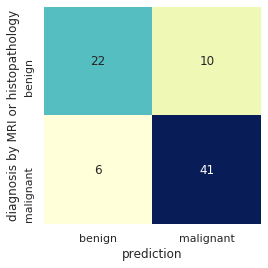

In [25]:
fig = plot_confusion_matrix(complete, np.array(complete_expert_predictions[0]))
fig.savefig("figures/complete-expert-1-confusion-matrix-experts.svg", bbox_inches = "tight")

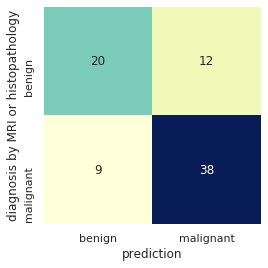

In [26]:
fig = plot_confusion_matrix(complete, np.array(complete_expert_predictions[1]))
fig.savefig("figures/complete-expert-2-confusion-matrix-experts.svg", bbox_inches = "tight")

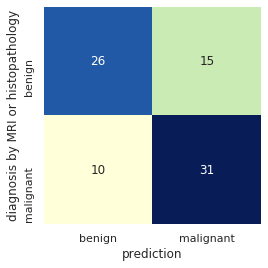

In [27]:
fig = plot_confusion_matrix(uncertain, np.array(uncertain_expert_predictions[0]))
fig.savefig("figures/uncertain-expert-1-confusion-matrix-experts.svg", bbox_inches = "tight")

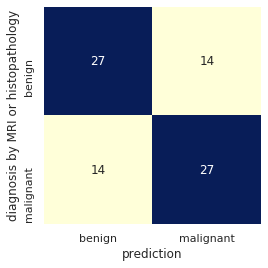

In [28]:
fig = plot_confusion_matrix(uncertain, np.array(uncertain_expert_predictions[1]))
fig.savefig("figures/uncertain-expert-2-confusion-matrix-experts.svg", bbox_inches = "tight")

In [29]:
def four_group(basename="figures/accuracy-by-category-{}-{}.svg", X1=70, Y1=10, X2=460, Y2=290, width="750pt", height="450pt"):
    figures = list()
    plots = list()
    fig = sg.SVGFigure(width, height)
    movements = {
        ("expert-1", "complete"): (X1, Y1),
        ("expert-2", "complete"): (X1, Y2), 
        ("expert-1", "uncertain"): (X2, Y1),
        ("expert-2", "uncertain"): (X2, Y2), 
    }
    for crop in ["expert-1", "expert-2"]: 
        for subset in ["complete", "uncertain"]:
            f = sg.fromfile(basename.format(subset, crop))
            figures.append(f)
            plot = f.getroot()
            plot.moveto(movements[(crop, subset)][0], movements[(crop, subset)][1])
            plots.append(plot)
            fig.append([plot])
    txt1 = sg.TextElement(0, Y2/2, "expert 1", size=12, weight="bold")
    txt2 = sg.TextElement(0, Y2 + Y2/2, "expert 2", size=12, weight="bold")
    txt3 = sg.TextElement(X2/3, 12, "complete", size=12, weight="bold")
    txt4 = sg.TextElement(X2 + X2/5,12, "uncertain subgroup", size=12, weight="bold")
    fig.append([txt1, txt2, txt3, txt4])
    fig.save(basename.format("all", "all"))
    return SVG(basename.format("all", "all"))

In [30]:
fig = four_group("figures/{}-{}-confusion-matrix-experts.svg")

In [31]:
print("##### Train")
df = get_statistics(TRAIN)
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))

print("##### Validation")
df = get_statistics(VALIDATION)
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))

print("##### Complete Set Test")
df = get_statistics(COMPLETE_TEST, experts=complete_expert_predictions, modalities=COMPLETE_MODALITIES)
test_statistics = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))

print("##### Uncertain Set Test")
df = get_statistics(UNCERTAIN_TEST, experts=uncertain_expert_predictions, modalities=UNCERTAIN_MODALITIES)
test_statistics_uncertain = df
df = df.drop(['Acc', "TPR", "TNR", "Total", "Malignant", "Benign", "acc-low", "acc-high"], axis=1)
print(tabulate(df, tablefmt="pipe", headers="keys", floatfmt="#.2g").replace("nan", "N/A").replace("Features", "Clinical"))

df = get_statistics(TEST, experts=[[1 for _ in range(len(TEST["free-labels"]))]])
test_statistics_zero = df
df = get_statistics(UNCERTAIN_TEST, experts=[[1 for _ in range(len(TEST["uncertain-free-labels"]))]], modalities=UNCERTAIN_MODALITIES)
test_statistics_zero_uncertain = df

##### Train
| Modality          |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |   FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     |
|:------------------|-----------:|----------:|---------:|------:|------:|------:|:-----------------|:-----------------|:-----------------|
| Free - Complete   |       0.95 |      0.99 |     0.99 |  0.98 |  0.90 | 0.020 | 0.95 (0.93-0.96) | 0.92 (0.89-0.95) | 0.97 (0.95-0.99) |
| Fixed - Complete  |       0.93 |      0.95 |     0.95 |  0.88 |  0.98 | 0.12  | 0.92 (0.89-0.94) | 0.99 (0.97-1.00) | 0.82 (0.78-0.87) |
| Free - Uncertain  |       0.86 |      0.95 |     0.96 |  0.93 |  0.82 | 0.072 | 0.87 (0.82-0.90) | 0.80 (0.73-0.86) | 0.93 (0.88-0.97) |
| Fixed - Uncertain |       0.94 |      0.98 |     0.98 |  0.93 |  0.94 | 0.073 | 0.93 (0.90-0.96) | 0.94 (0.90-0.97) | 0.92 (0.87-0.96) |
##### Validation
| Modality          |   F1 Score |   ROC AUC |   PR AUC |   PPV |   NPV |   FDR | Acc (95% CI)     | TPR (95% CI)     | TNR (95% CI)     

/home/intrepidlemon/deep-ultrasound/evaluate.py:107: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:109: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN / (TN + FN)
/home/intrepidlemon/deep-ultrasound/evaluate.py:115: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:107: RuntimeWarning: invalid value encountered in true_divide
  PPV = TP / (TP + FP)
/home/intrepidlemon/deep-ultrasound/evaluate.py:109: RuntimeWarning: invalid value encountered in true_divide
  NPV = TN / (TN + FN)
/home/intrepidlemon/deep-ultrasound/evaluate.py:115: RuntimeWarning: invalid value encountered in true_divide
  FDR = FP / (TP + FP)


In [32]:
TEST.keys()

dict_keys(['free-labels', 'free-predictions', 'free-probabilities', 'fixed-labels', 'fixed-predictions', 'fixed-probabilities', 'uncertain-free-labels', 'uncertain-free-predictions', 'uncertain-free-probabilities', 'uncertain-fixed-labels', 'uncertain-fixed-predictions', 'uncertain-fixed-probabilities'])

In [33]:
test_statistics_zero

,F1 Score,ROC AUC,PR AUC,Acc,TPR,TNR,PPV,NPV,FDR,Total,Malignant,Benign,Acc (95% CI),TPR (95% CI),TNR (95% CI),acc-low,acc-high
Modality,,,,,,,,,,,,,,,,,
Free - Complete,0.863,0.828,0.855,0.835,0.872,0.781,0.854,0.806,0.146,79,47,32,0.84 (0.74-0.90),0.87 (0.74-0.94),0.78 (0.61-0.89),0.737,0.903
Fixed - Complete,0.843,0.846,0.872,0.797,0.915,0.625,0.782,0.833,0.218,79,47,32,0.80 (0.70-0.87),0.91 (0.80-0.97),0.62 (0.45-0.77),0.695,0.872
Free - Uncertain,0.795,0.785,0.745,0.793,0.805,0.780,0.786,0.800,0.214,82,41,41,0.79 (0.69-0.87),0.80 (0.66-0.90),0.78 (0.63-0.88),0.692,0.867
Fixed - Uncertain,0.727,0.766,0.768,0.707,0.780,0.634,0.681,0.743,0.319,82,41,41,0.71 (0.60-0.80),0.78 (0.63-0.88),0.63 (0.48-0.76),0.601,0.795
Expert 1,0.746,nan,nan,0.595,1.000,0.000,0.595,nan,0.405,79,47,32,0.59 (0.48-0.70),1.00 (0.91-1.00),0.00 (0.00-0.13),0.485,0.696


In [34]:
COMPLETE_TRAIN.keys()

dict_keys(['free-labels', 'free-predictions', 'free-probabilities', 'fixed-labels', 'fixed-predictions', 'fixed-probabilities'])

free 660 660 660
fixed 660 660 660
free 172 172 172
fixed 172 172 172
free 79 79 79
fixed 79 79 79
uncertain-free 314 314 314
uncertain-fixed 314 314 314
uncertain-free 80 80 80
uncertain-fixed 80 80 80
uncertain-free 82 82 82
uncertain-fixed 82 82 82


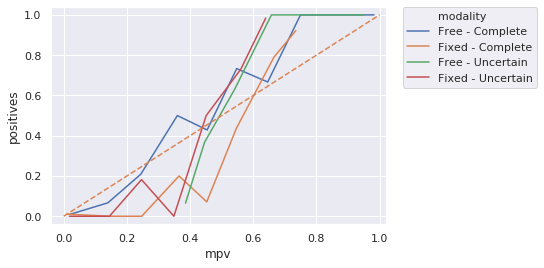

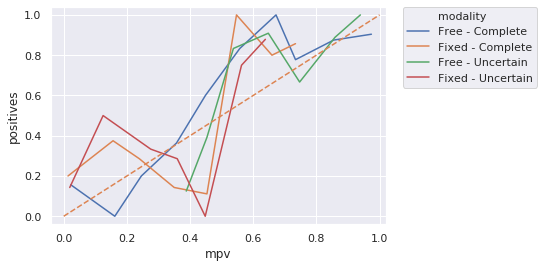

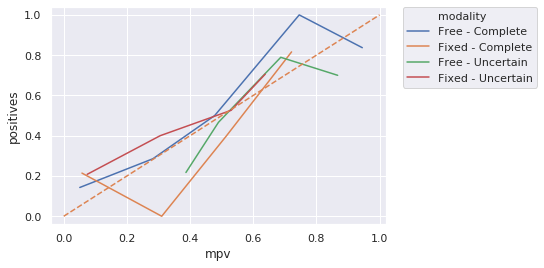

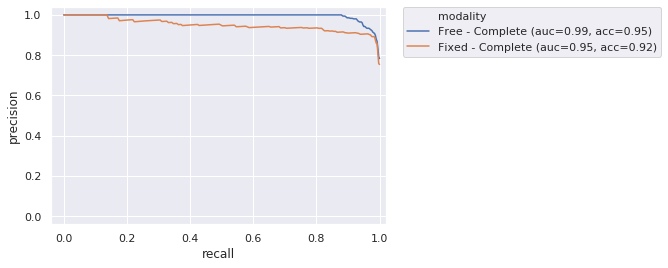

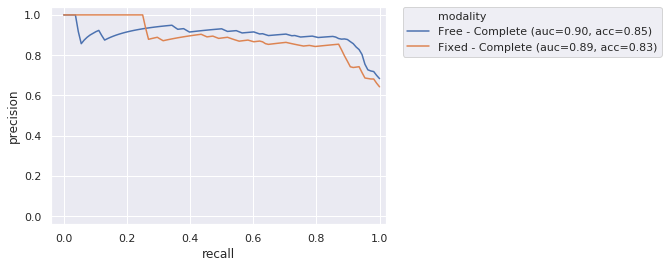

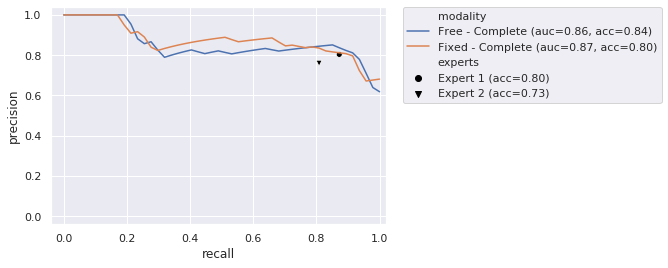

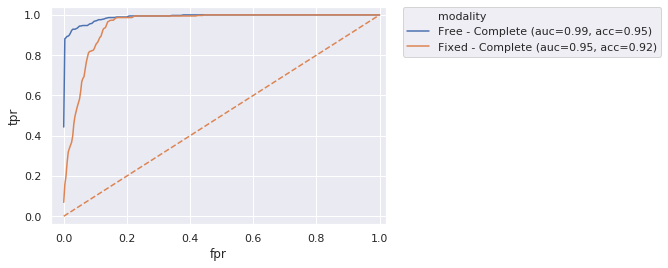

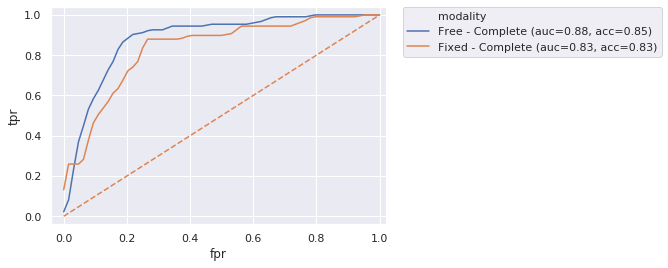

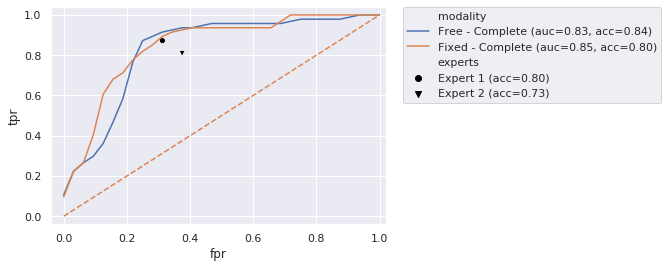

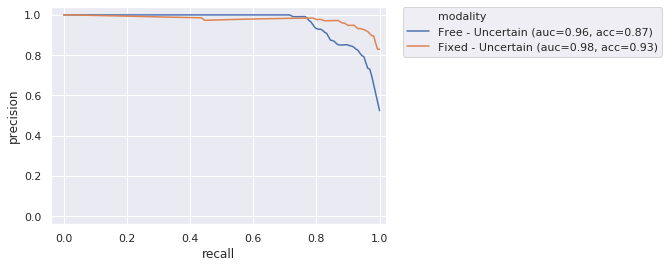

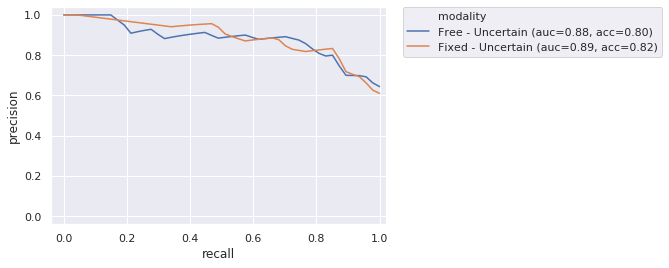

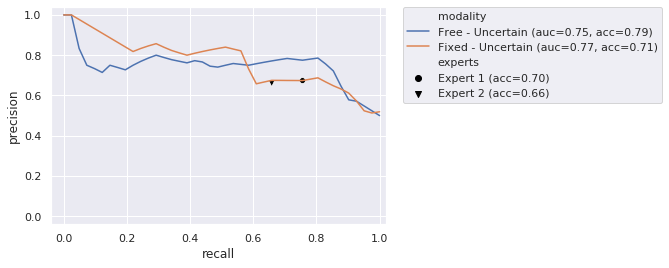

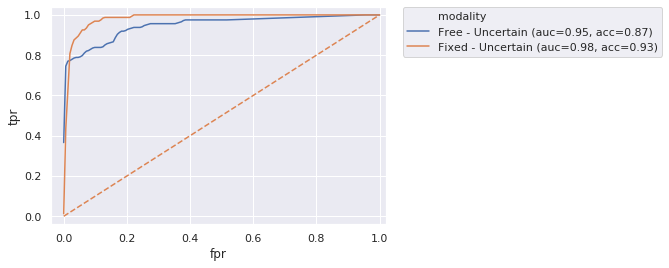

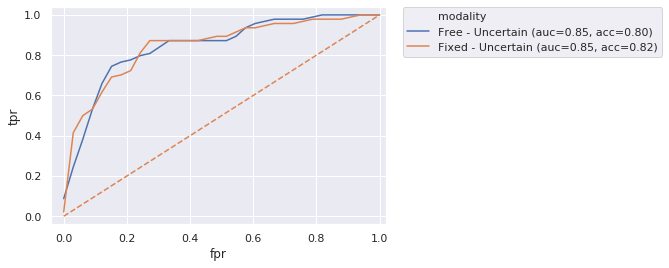

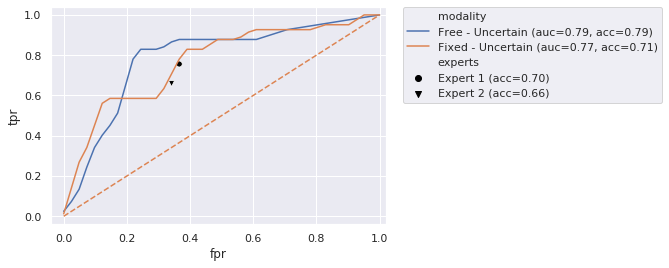

In [35]:
fig = plot_multiple_reliability_curve(TRAIN)
fig.savefig("figures/train-reliability-curve.svg", bbox_inches = "tight")
fig = plot_multiple_reliability_curve(VALIDATION)
fig.savefig("figures/validation-reliability-curve.svg", bbox_inches = "tight")
fig = plot_multiple_reliability_curve(TEST, n_bins=5)
fig.savefig("figures/test-reliability-curve.svg", bbox_inches = "tight")


fig = plot_multiple_precision_recall(COMPLETE_TRAIN,  modalities=COMPLETE_MODALITIES)
fig.savefig("figures/complete-train-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(COMPLETE_VALIDATION,  modalities=COMPLETE_MODALITIES)
fig.savefig("figures/complete-validation-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(COMPLETE_TEST,  modalities=COMPLETE_MODALITIES, experts=np.array(complete_expert_predictions))
fig.savefig("figures/complete-test-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(COMPLETE_TRAIN,  modalities=COMPLETE_MODALITIES)
fig.savefig("figures/complete-train-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(COMPLETE_VALIDATION,  modalities=COMPLETE_MODALITIES)
fig.savefig("figures/complete-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(COMPLETE_TEST,  modalities=COMPLETE_MODALITIES, experts=np.array(complete_expert_predictions))
fig.savefig("figures/complete-test-roc.svg", bbox_inches = "tight")

fig = plot_multiple_precision_recall(UNCERTAIN_TRAIN, modalities=UNCERTAIN_MODALITIES)
fig.savefig("figures/uncertain-train-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(UNCERTAIN_VALIDATION, modalities=UNCERTAIN_MODALITIES)
fig.savefig("figures/uncertain-validation-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_precision_recall(UNCERTAIN_TEST, modalities=UNCERTAIN_MODALITIES, experts=np.array(uncertain_expert_predictions))
fig.savefig("figures/uncertain-test-precision-recall.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(UNCERTAIN_TRAIN, modalities=UNCERTAIN_MODALITIES)
fig.savefig("figures/uncertain-train-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(UNCERTAIN_VALIDATION, modalities=UNCERTAIN_MODALITIES)
fig.savefig("figures/uncertain-validation-roc.svg", bbox_inches = "tight")
fig = plot_multiple_roc_curve(UNCERTAIN_TEST, modalities=UNCERTAIN_MODALITIES, experts=np.array(uncertain_expert_predictions))
fig.savefig("figures/uncertain-test-roc.svg", bbox_inches = "tight")

In [36]:
test_statistics

,F1 Score,ROC AUC,PR AUC,Acc,TPR,TNR,PPV,NPV,FDR,Total,Malignant,Benign,Acc (95% CI),TPR (95% CI),TNR (95% CI),acc-low,acc-high
Modality,,,,,,,,,,,,,,,,,
Free - Complete,0.863,0.828,0.855,0.835,0.872,0.781,0.854,0.806,0.146,79,47,32,0.84 (0.74-0.90),0.87 (0.74-0.94),0.78 (0.61-0.89),0.737,0.903
Fixed - Complete,0.843,0.846,0.872,0.797,0.915,0.625,0.782,0.833,0.218,79,47,32,0.80 (0.70-0.87),0.91 (0.80-0.97),0.62 (0.45-0.77),0.695,0.872
Expert 1,0.837,nan,nan,0.797,0.872,0.688,0.804,0.786,0.196,79,47,32,0.80 (0.70-0.87),0.87 (0.74-0.94),0.69 (0.51-0.82),0.695,0.872
Expert 2,0.784,nan,nan,0.734,0.809,0.625,0.760,0.690,0.240,79,47,32,0.73 (0.63-0.82),0.81 (0.67-0.90),0.62 (0.45-0.77),0.627,0.820


In [37]:
test_statistics_uncertain

,F1 Score,ROC AUC,PR AUC,Acc,TPR,TNR,PPV,NPV,FDR,Total,Malignant,Benign,Acc (95% CI),TPR (95% CI),TNR (95% CI),acc-low,acc-high
Modality,,,,,,,,,,,,,,,,,
Free - Uncertain,0.795,0.785,0.745,0.793,0.805,0.780,0.786,0.800,0.214,82,41,41,0.79 (0.69-0.87),0.80 (0.66-0.90),0.78 (0.63-0.88),0.692,0.867
Fixed - Uncertain,0.727,0.766,0.768,0.707,0.780,0.634,0.681,0.743,0.319,82,41,41,0.71 (0.60-0.80),0.78 (0.63-0.88),0.63 (0.48-0.76),0.601,0.795
Expert 1,0.713,nan,nan,0.695,0.756,0.634,0.674,0.722,0.326,82,41,41,0.70 (0.59-0.78),0.76 (0.60-0.86),0.63 (0.48-0.76),0.588,0.785
Expert 2,0.659,nan,nan,0.659,0.659,0.659,0.659,0.659,0.341,82,41,41,0.66 (0.55-0.75),0.66 (0.50-0.79),0.66 (0.50-0.79),0.551,0.752


In [45]:
CI_text = """{value:#.2g} (95% CI: {low:#.2g}-{high:#.2g})"""

statistics_text = """test accuracy of {accuracy}, F1 score of {f1:#.2g}, and sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
    }
    return statistics_text.format(**data_dict)

mini_statistics_text = """test accuracy of {accuracy}"""
def format_mini_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
    }
    return mini_statistics_text.format(**data_dict)

statistics_AUC_text = """test accuracy of {accuracy}, F1 score of {f1:#.2g}, precision recall AUC of {PR_AUC:#.2g}, sensitivity of {sensitivity}, and specificity of {specificity}"""
def format_AUC_statistics(data):
    acc_low, acc_high = adjusted_wald(data["Acc"], data["Total"])
    tpr_low, tpr_high = adjusted_wald(data["TPR"], data["Malignant"])
    tnr_low, tnr_high = adjusted_wald(data["TNR"], data["Benign"])
    data_dict = {
        "accuracy": CI_text.format(value=data["Acc"], low=acc_low, high=acc_high),
        "sensitivity": CI_text.format(value=data["TPR"], low=tpr_low, high=tpr_high),
        "specificity": CI_text.format(value=data["TNR"], low=tnr_low, high=tnr_high),
        "f1": data["F1 Score"],
        "PR_AUC": data["PR AUC"],
    }
    return statistics_AUC_text.format(**data_dict)

comparison_text ="""{accuracy_judge} test accuracy ({accuracy_1:#.2g} vs. {accuracy_2:#.2g}, p={accuracy_p:#.2g}), {sensitivity_judge} test sensitivity ({sensitivity_1:#.2g} vs. {sensitivity_2:#.2g}, p={sensitivity_p:#.2g}) and {specificity_judge} test specificity ({specificity_1:#.2g} vs. {specificity_2:#.2g}, p={specificity_p:#.2g})"""
def format_comparison_text(data_1, data_2):
    data_dict = {
        "accuracy_judge": "higher" if data_1["Acc"] > data_2["Acc"] else "lower",
        "sensitivity_judge": "higher" if data_1["TPR"] > data_2["TPR"] else "lower",
        "specificity_judge": "higher" if data_1["TNR"] > data_2["TNR"] else "lower",
        "accuracy_1": data_1["Acc"],
        "specificity_1": data_1["TNR"],
        "sensitivity_1": data_1["TPR"],
        "accuracy_2": data_2["Acc"],
        "specificity_2": data_2["TNR"],
        "sensitivity_2": data_2["TPR"],
        "accuracy_p": binom_test(int(data_1["Acc"] * data_1["Total"]), data_1["Total"], data_2["Acc"]),
        "specificity_p": binom_test(int(data_1["TNR"] * data_1["Benign"]), data_1["Benign"], data_2["TNR"]),
        "sensitivity_p": binom_test(int(data_1["TPR"] * data_1["Malignant"]), data_1["Malignant"], data_2["TPR"]),
    }
    return comparison_text.format(**data_dict)

mini_comparison_text ="""{accuracy_judge} test accuracy ({accuracy_1:#.2g} vs. {accuracy_2:#.2g}, p={accuracy_p:#.2g})"""
def format_mini_comparison_text(data_1, data_2):
    data_dict = {
        "accuracy_judge": "higher" if data_1["Acc"] > data_2["Acc"] else "lower",
        "accuracy_1": data_1["Acc"],
        "accuracy_2": data_2["Acc"],
        "accuracy_p": binom_test(int(data_1["Acc"] * data_1["Total"]), data_1["Total"], data_2["Acc"]),
    }
    return mini_comparison_text.format(**data_dict)


results_text = """
## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1).

The model trained on all free segmentation images achieved a {free_statistics}. The model trained on all fixed segmentation images achieved a {fixed_statistics}. 

The model trained on uncertain free segmentation images achieved a {uncertain_free_statistics}. The model trained on uncertain fixed segmentation images achieved a {uncertain_fixed_statistics}. 

In comparison, on the complete set of all images, expert 1 achieved a {expert_1_statistics}; expert 2 had a {expert_2_statistics}. On the uncertain set of images, expert 1 achieved a {uncertain_expert_1_statistics} and expert 2 achieved a {uncertain_expert_2_statistics}. 

Compared to a baseline zero rule algorithm, the free segmentation deep learning model had {free_vs_zero}. On the complete dataset, compared to all experts averaged, the free segmentation deep learning model had {free_vs_experts} and the fixed segmentation model had {fixed_vs_experts}. On the uncertain dataset, compared to all experts averaged, the free segmentation deep learning model had {free_vs_experts_uncertain} and the fixed segmentation model had {fixed_vs_experts_uncertain}. Figure 1 shows the ROC curves of all models overlaid with expert performance.

Figure 2 breaks down accuracy performance of models and experts by Code Abdomen category. t-SNE representation of the final dense layer of ResNet demonstrates good separation of malignant and benign lesions by the model when compared to histopathological diagnosis (Figure 3).

"""

print(results_text.format(
    free_statistics=format_AUC_statistics(dict(test_statistics.loc["Free - Complete"])),
    fixed_statistics=format_AUC_statistics(dict(test_statistics.loc["Fixed - Complete"])),
    uncertain_free_statistics=format_AUC_statistics(dict(test_statistics_uncertain.loc["Free - Uncertain"])),
    uncertain_fixed_statistics=format_AUC_statistics(dict(test_statistics_uncertain.loc["Fixed - Uncertain"])),    
    expert_1_statistics=format_statistics(dict(test_statistics.loc["Expert 1"])), 
    expert_2_statistics=format_statistics(dict(test_statistics.loc["Expert 2"])), 
    uncertain_expert_1_statistics=format_statistics(dict(test_statistics_uncertain.loc["Expert 1"])), 
    uncertain_expert_2_statistics=format_statistics(dict(test_statistics_uncertain.loc["Expert 2"])),     
    free_vs_zero=format_mini_comparison_text(dict(test_statistics.loc["Free - Complete"]), dict(test_statistics_zero.loc["Expert 1"])),
    free_vs_experts=format_comparison_text(dict(test_statistics.loc["Free - Complete"]), dict(test_statistics.loc[["Expert 1", "Expert 2"]].mean())), 
    fixed_vs_experts=format_comparison_text(dict(test_statistics.loc["Fixed - Complete"]), dict(test_statistics.loc[["Expert 1", "Expert 2"]].mean())), 
    free_vs_experts_uncertain=format_comparison_text(dict(test_statistics_uncertain.loc["Free - Uncertain"]), dict(test_statistics_uncertain.loc[["Expert 1", "Expert 2"]].mean())), 
    fixed_vs_experts_uncertain=format_comparison_text(dict(test_statistics_uncertain.loc["Fixed - Uncertain"]), dict(test_statistics_uncertain.loc[["Expert 1", "Expert 2"]].mean())), 
))

abstract_results_text ="""
Our model trained on the complete set of all lesions achieved a {free_statistics} compared to expert 1 with a {expert_1_statistics} and expert 2 with a {expert_2_statistics}. Our model trained on the uncertain set of lesions achieved a {uncertain_free_statistics} compared to expert 1 with a {uncertain_expert_1_statistics} and expert 2 with a {uncertain_expert_2_statistics}. On the complete dataset, compared to all experts averaged, the free segmentation deep learning model had {free_vs_experts}. On the uncertain dataset, compared to all experts averaged, the free segementation model had {free_vs_experts_uncertain}
"""
print("####ABSTRACT")
print(abstract_results_text.format(
    free_statistics=format_mini_statistics(dict(test_statistics.loc["Free - Complete"])),
    uncertain_free_statistics=format_mini_statistics(dict(test_statistics_uncertain.loc["Free - Uncertain"])),
    expert_1_statistics=format_mini_statistics(dict(test_statistics.loc["Expert 1"])), 
    expert_2_statistics=format_mini_statistics(dict(test_statistics.loc["Expert 2"])), 
    uncertain_expert_1_statistics=format_mini_statistics(dict(test_statistics_uncertain.loc["Expert 1"])), 
    uncertain_expert_2_statistics=format_mini_statistics(dict(test_statistics_uncertain.loc["Expert 2"])),
    free_vs_experts=format_mini_comparison_text(dict(test_statistics.loc["Free - Complete"]), dict(test_statistics.loc[["Expert 1", "Expert 2"]].mean())), 
    free_vs_experts_uncertain=format_mini_comparison_text(dict(test_statistics_uncertain.loc["Free - Uncertain"]), dict(test_statistics_uncertain.loc[["Expert 1", "Expert 2"]].mean())),     
))



## Model performance
The train, validation and test sets were balanced in terms of age, gender, tumor size, tumor laterality, tumor location, histologic diagnosis, and institution (Supplemental table S1).

The model trained on all free segmentation images achieved a test accuracy of 0.84 (95% CI: 0.74-0.90), F1 score of 0.86, precision recall AUC of 0.86, sensitivity of 0.87 (95% CI: 0.74-0.94), and specificity of 0.78 (95% CI: 0.61-0.89). The model trained on all fixed segmentation images achieved a test accuracy of 0.80 (95% CI: 0.70-0.87), F1 score of 0.84, precision recall AUC of 0.87, sensitivity of 0.91 (95% CI: 0.80-0.97), and specificity of 0.62 (95% CI: 0.45-0.77). 

The model trained on uncertain free segmentation images achieved a test accuracy of 0.79 (95% CI: 0.69-0.87), F1 score of 0.80, precision recall AUC of 0.75, sensitivity of 0.80 (95% CI: 0.66-0.90), and specificity of 0.78 (95% CI: 0.63-0.88). The model trained on uncertain fixed segmentation images achieved a te

In [39]:
test_statistics

,F1 Score,ROC AUC,PR AUC,Acc,TPR,TNR,PPV,NPV,FDR,Total,Malignant,Benign,Acc (95% CI),TPR (95% CI),TNR (95% CI),acc-low,acc-high
Modality,,,,,,,,,,,,,,,,,
Free - Complete,0.863,0.828,0.855,0.835,0.872,0.781,0.854,0.806,0.146,79,47,32,0.84 (0.74-0.90),0.87 (0.74-0.94),0.78 (0.61-0.89),0.737,0.903
Fixed - Complete,0.843,0.846,0.872,0.797,0.915,0.625,0.782,0.833,0.218,79,47,32,0.80 (0.70-0.87),0.91 (0.80-0.97),0.62 (0.45-0.77),0.695,0.872
Expert 1,0.837,nan,nan,0.797,0.872,0.688,0.804,0.786,0.196,79,47,32,0.80 (0.70-0.87),0.87 (0.74-0.94),0.69 (0.51-0.82),0.695,0.872
Expert 2,0.784,nan,nan,0.734,0.809,0.625,0.760,0.690,0.240,79,47,32,0.73 (0.63-0.82),0.81 (0.67-0.90),0.62 (0.45-0.77),0.627,0.820


# Image visualizations

In [40]:
COLUMNS = 5
# from harrison
selection_index = {
    ("free", "uncertain"): {
        (0, 0): [1, 6, 8, 13, 15], 
        (0, 1): [0, 1, 2],
        (1, 0): [0, 1, 2, 3],
        (1, 1): [3, 4, 5, 6, 7],
    }, 
}
selection = { (crop, subset): dict() for crop in CROPS for subset in SUBSETS } 
for crop in CROPS: 
    for subset in SUBSETS:
        if crop == "free" and subset == "uncertain": 
            display(HTML("<h3>{}-{}</h3>".format(crop, subset)))
            correct_incorrect = CORRECT_INCORRECT[(crop, subset)]
            by_correctness = {
                (0, 0): list(), 
                (1, 1): list(), 
                (0, 1): list(), 
                (1, 0): list(),
            }
            dataset = DATASETS[(crop, subset)]
            inv_indices = {v: k for k, v in dataset.class_indices.items()}
            for k, v in correct_incorrect.items(): 
                by_correctness[v].append(k)
            for k, v in by_correctness.items():
                display(HTML("<h5>diagnosis: {} | prediction: {}</h5>".format(inv_indices[k[0]], inv_indices[k[1]])))
                rows = int(math.ceil(len(v)/COLUMNS))
                f, ax = plt.subplots(rows, COLUMNS, figsize=(18, 3 * rows))
                ax = ax.flatten()
                selection_indices = selection_index.get((crop, subset), dict()).get((k[0], k[1]), list())
                selection[(crop, subset)][(k[0], k[1])] = [v[i] for i in selection_indices]
                for i, filename in enumerate(v): 
                    image_file = "{}/validation/{}".format(DATA_FOLDERS[(crop, subset)], filename)
                    image = load_img(image_file, target_size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
                    m = filename.split("-")
                    m.pop(0)
                    accession = m.pop(0)
                    accession = accession.split("/")[0]
                #    print("https://cf151f9a.ngrok.io/{}/{}".format(accession, "-".join(m)))
                    ax[i].imshow(image)
                for a in ax: 
                    a.axis('off')
                plt.show()

NameError: name 'SUBSETS' is not defined

# Evaluate all models

In [ ]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')